In [1]:
cd C:/Jade/thesis/data/Yu-Jie 11 strains 2/

C:\Jade\thesis\data\Yu-Jie 11 strains 2


In [2]:
pwd

'C:\\Jade\\thesis\\data\\Yu-Jie 11 strains 2'

In [3]:
pip list

Package                   Version
------------------------- --------------
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
exceptiongroup            1.2.0
executing                 2.0.1
fastjsonschema            2.19.1
fonttools                 4.51.0
fqdn                      1.5.1
h11                       0.14.0
httpcore                  1.0.5
httpx                     0.27.0
idna           

In [3]:
import pickle
import pandas as pd
from pathlib import Path
import tifffile as tiff
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.ndimage
from skimage.draw import polygon2mask
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import regionprops_table, label
from skimage.draw import polygon2mask
from skimage.morphology import closing, erosion
from shapely.geometry import Polygon
from scipy.stats import zscore
import seaborn as sns
from matplotlib.patches import Patch
from scipy.stats import shapiro

<h2>Import feature data

In [4]:
pkl_file = 'C:/Jade/thesis/data/Yu-Jie 11 strains 2/AllData.pkl'
with open(pkl_file, "rb") as file:
  result_dataframes = pickle.load(file)

<h3>Dimension reduction and visualization

<h4> Preparation of data for dimension reduction

In [43]:
n_strains = len(result_dataframes['strain'].unique())
print(n_strains)

11


In [44]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Select data for following plots
n_conditions = len(result_dataframes['strain'].unique())

# Robust scale numeric data
df_numeric = result_dataframes.select_dtypes(np.number)
print(df_numeric.head())

#robust scaling ## you can choose or not
# scaler = RobustScaler()
# robustZscore_transformed_numeric = scaler.fit_transform(df_numeric)
# robustZscore_transformed_numeric = pd.DataFrame(robustZscore_transformed_numeric)
# print(robustZscore_transformed_numeric.head())


   C2_NC_ratio  C2_avg_pole_object_distance  C2_cell_avg_midline_sinuosity   
0     0.633211                     1.642329                          1.001  \
1     0.536196                     1.566326                          1.005   
2     0.536852                     1.343396                          1.000   
3     0.622640                     1.633153                          1.013   
4     0.555826                     1.005853                          1.000   

   C2_cell_avg_obj_SOV  C2_cell_avg_obj_aspectratio   
0             5.137698                     2.926664  \
1             5.229720                     2.535428   
2             5.781618                     2.469550   
3             4.849063                     2.707568   
4             4.735311                     1.509061   

   C2_cell_avg_obj_circularity  C2_cell_avg_obj_compactness   
0                     0.620693                    20.245726  \
1                     0.730817                    17.194952   
2          

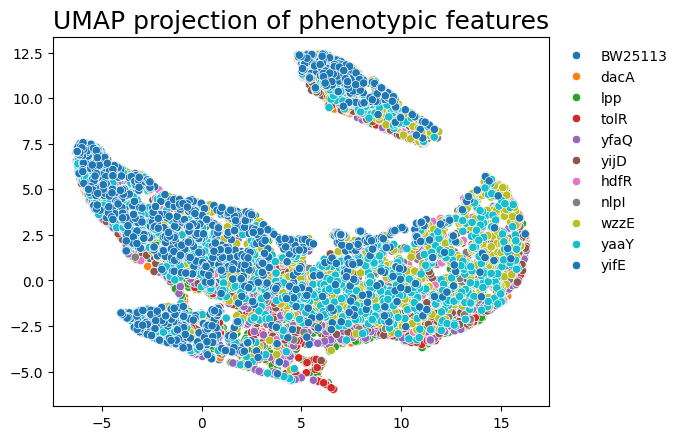

In [45]:
import umap
# Initializing the UMAP instance
reduce_umap = umap.UMAP()

# Train the reducer to create embedding
embedding_umap = reduce_umap.fit_transform(df_numeric)

# Plot embedding as scatterplot
ax = sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=result_dataframes.strain,
    palette=sns.color_palette("tab10", n_colors=n_strains))

plt.title('UMAP projection of phenotypic features', fontsize=18)

leg = ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

ML classification

Preparation of data for classification

In [44]:

pkl_file = 'C:/Jade/thesis/data/Yu-Jie 11 strains 2/AllData.pkl'
with open(pkl_file, "rb") as file:
  result_dataframes = pickle.load(file)


# Create a binary target column for whether the condition is "Control" or not
result_dataframes['strain'] = (result_dataframes['strain'] == 'BW25113').astype(int)

# Split the data into features and target
X = result_dataframes.drop(columns=['strain']).select_dtypes(include=[np.number])
y = result_dataframes['strain']

Train the LDA classifier and use GridSearchCV to find hyperparamters

Best Hyperparameters: {'classifier__solver': 'svd'}


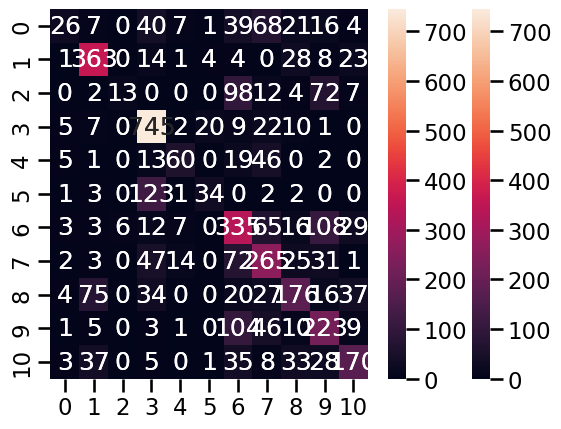

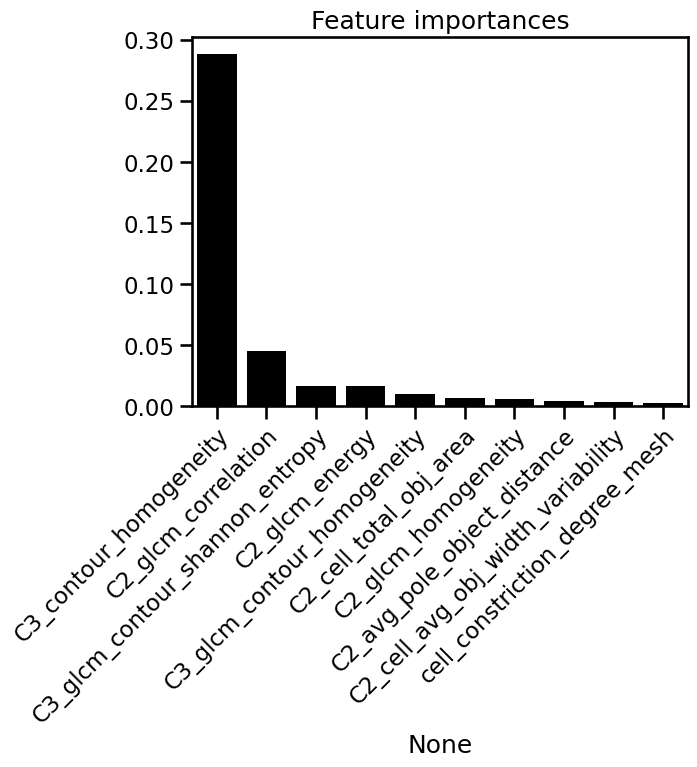

In [45]:

# Import the necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import joblib

saving_path_classif = 'C:/Jade/thesis/data/Yu-Jie 11 strains 2/'


# Create the pipeline for preprocessing and classification
pipeline = Pipeline([
    ('classifier', LinearDiscriminantAnalysis())  #('scaler', StandardScaler()),
])

# Define the hyperparameter search space
param_grid = {'classifier__solver': ['svd', 'lsqr']}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=42, stratify=y)

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the pipeline on the full training set with the best hyperparameters
pipeline.set_params(**grid_search.best_params_)
pipeline.fit(X_train, y_train)

# Save the pipeline 
joblib.dump(pipeline, saving_path_classif + 'LDA_classifier_pipeline.joblib')

# Get and plot feature importances
def plot_feature_importances(model, feature_names, top_n):
    model = model.named_steps["classifier"]

    importances = model.coef_[0]
    # Normalize the importances
    importances = importances / np.sum(np.abs(importances))

    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure()
    sns.barplot(x=feature_names[indices], y=importances[indices], color="black")
    plt.title("Feature importances")
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.savefig(saving_path_classif + 'FeatureImportances_LDA.pdf', bbox_inches='tight')
    plt.show()


plot_feature_importances(pipeline, X.columns, top_n=10)




Evaluate trained LDA classifier on test set


       strain  True Control  Pred Control  Control Prob
1458        0             0             0      0.000708
13439       0             0             0      0.032386
300         1             1             0      0.190792
5919        0             0             0      0.013601
7473        0             0             0      0.003884
...       ...           ...           ...           ...
3846        0             0             0      0.010901
11560       0             0             0      0.154564
11609       0             0             0      0.049207
7713        0             0             0      0.025444
7035        0             0             0      0.023977

[1391 rows x 4 columns]
Accuracy on test set: 0.9518332135154565


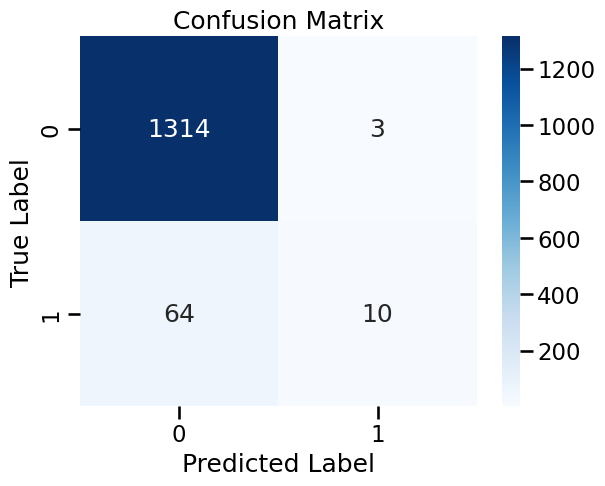

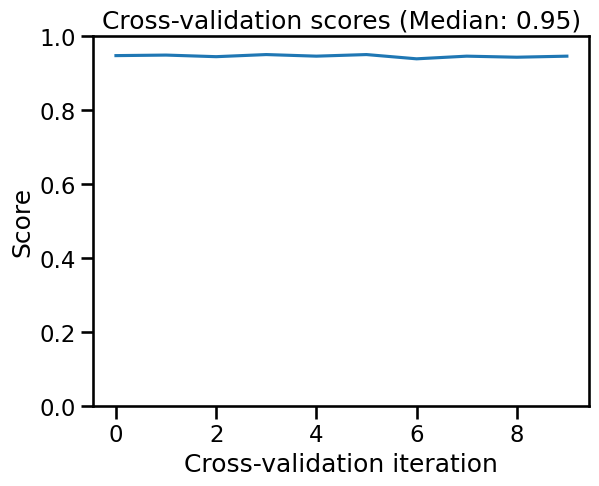

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Make predictions on the test set and get the probabilities of each sample belonging to the "Control" class
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Add the true condition labels to the results for comparison
results = pd.DataFrame({'strain': result_dataframes.loc[X_test.index, 'strain'],
                        'True Control': y_test,
                        'Pred Control': y_pred,
                        'Control Prob': y_probs})
print(results)

# Save results as table
# results.to_csv(saving_path_classif + 'Test_set_classification_LDA.csv')

# Evaluate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(saving_path_classif + 'Confusion_Matrix_LDA.pdf', bbox_inches='tight')
plt.show()

# Plot the cross-validation scores accross the whole dataset
scores = cross_val_score(pipeline, X, y, cv=10)
sns.lineplot(data=scores)
plt.xlabel("Cross-validation iteration")
plt.ylabel("Score")
plt.ylim(0, 1)
median_score = np.median(scores)
plt.title(f"Cross-validation scores (Median: {median_score:.2f})")
plt.savefig(saving_path_classif + 'CV_scores_LDA.pdf', bbox_inches='tight')
plt.show()